In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)

In [2]:
pd.set_option('display.float_format', '{:.2%}'.format)

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
start_date = '2024-01-01'

data = yf.download(tickers, start=start_date, progress=False)['Close'][tickers]
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma,
})
metricas.T

YF.download() has changed argument auto_adjust default to True


/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_49887/505867309.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rt = data.pct_change().dropna()


Ticker,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA
Rendimiento,12.45%,6.06%,14.06%,21.09%,23.86%,75.24%
Volatilidad,30.28%,23.57%,30.69%,32.03%,68.84%,58.44%


In [3]:
pd.reset_option('display.float_format')
prices_df = pd.DataFrame({
    'Precio Final': data.iloc[-1],
})
prices_df.T

Ticker,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA
Precio Final,NaN,383.5,NaN,184.593506,NaN,NaN


In [4]:
strikes = [205, 385, 160, 185, 255, 105]

In [5]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [6]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns
    
    def black_scholes_price(self, So, K, T, rf, sigma, option_type='call'):
        d1 = (np.log(So / K) + (rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = (So * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rf * T) * norm.cdf(d2, 0.0, 1.0))
        else:
            price = (K * np.exp(-rf * T) * norm.cdf(-d2, 0.0, 1.0) - So * norm.cdf(-d1, 0.0, 1.0))
        return price

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251], times=[1/12, 1/4, 1/2, 1]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i in range(len(self.tickers)):
            ticker = self.tickers[i]
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)

            for p, t in zip(periods, times):
                k = self.strikes[i]
                premium_call = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'call')
                premium_put = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'put')

                long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
                long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
                strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

                self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]
                win_rate = np.mean(profits > 0)

                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'La probabilidad de ganancia es de {win_rate:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()

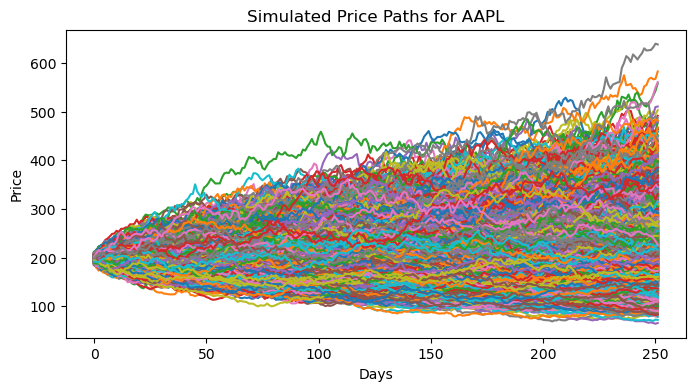

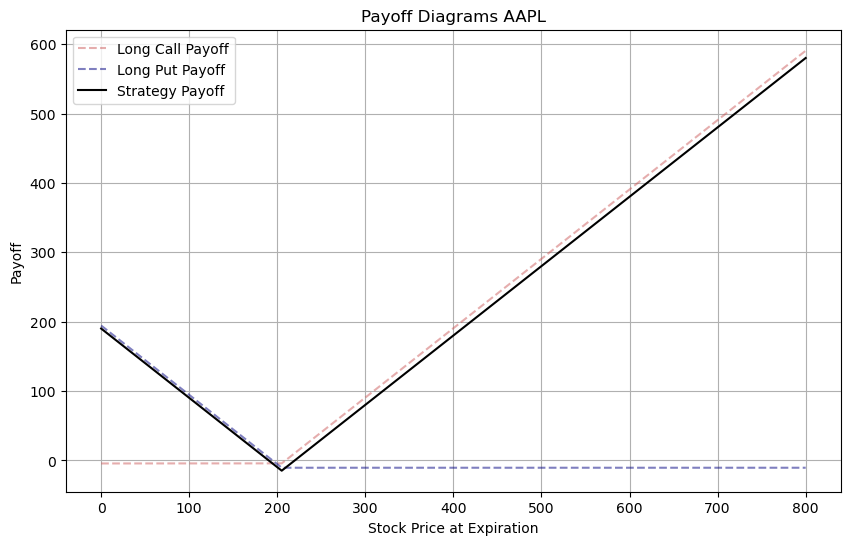

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-0.18
El rendimiento esperado de la estrategia es de -1.19%
La probabilidad de ganancia es de 42.69%
El intervalo de confianza del 95% para el profit es de [-14.219607624703093, 24.851545674357066]



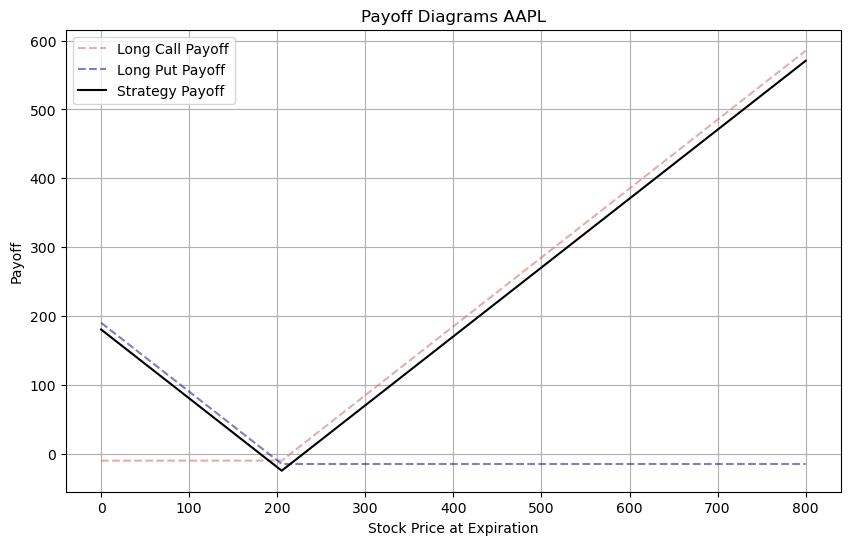

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.16
El rendimiento esperado de la estrategia es de 0.65%
La probabilidad de ganancia es de 42.92%
El intervalo de confianza del 95% para el profit es de [-23.386964114307492, 44.22819394156856]



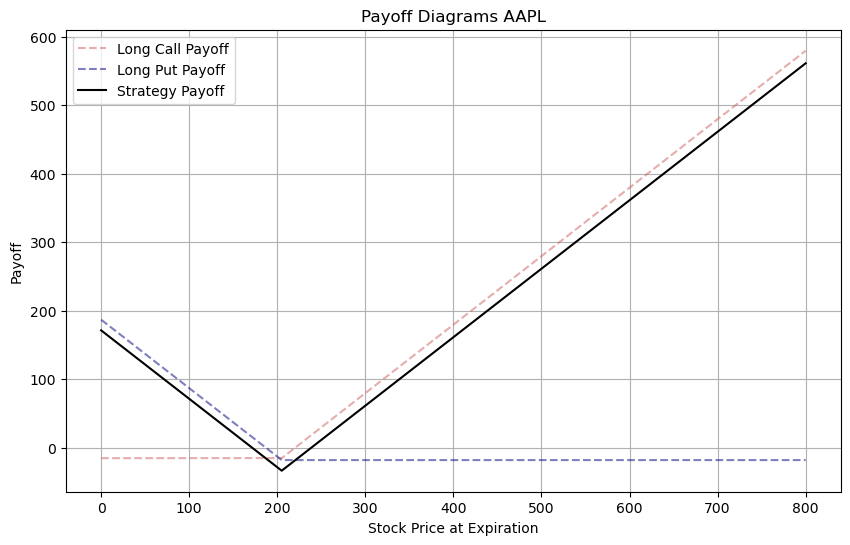

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $1.20
El rendimiento esperado de la estrategia es de 3.55%
La probabilidad de ganancia es de 43.27%
El intervalo de confianza del 95% para el profit es de [-32.53930548273497, 70.44887916900944]



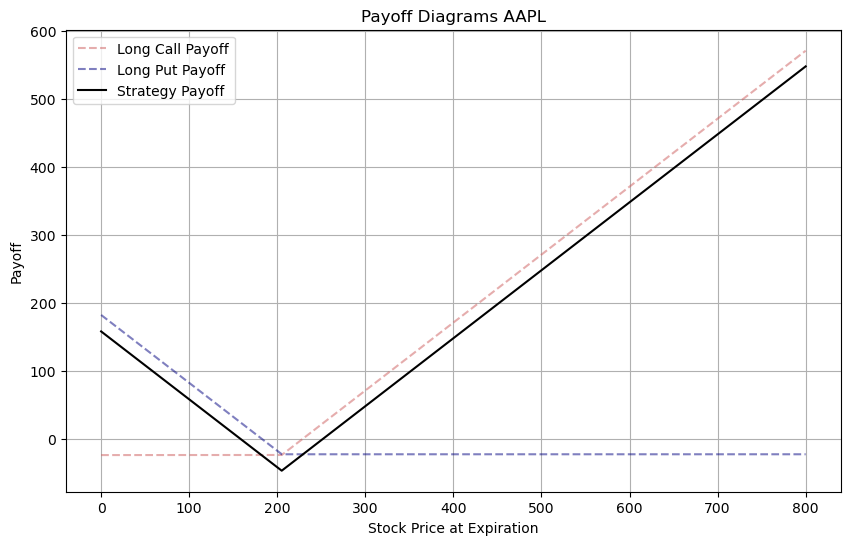

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $4.43
El rendimiento esperado de la estrategia es de 9.37%
La probabilidad de ganancia es de 43.99%
El intervalo de confianza del 95% para el profit es de [-45.39174481709041, 123.97370020819214]



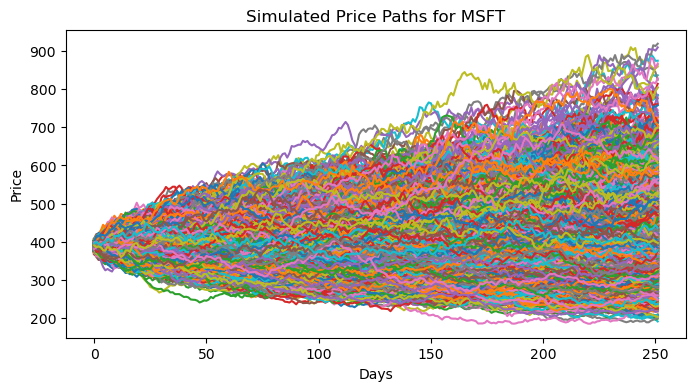

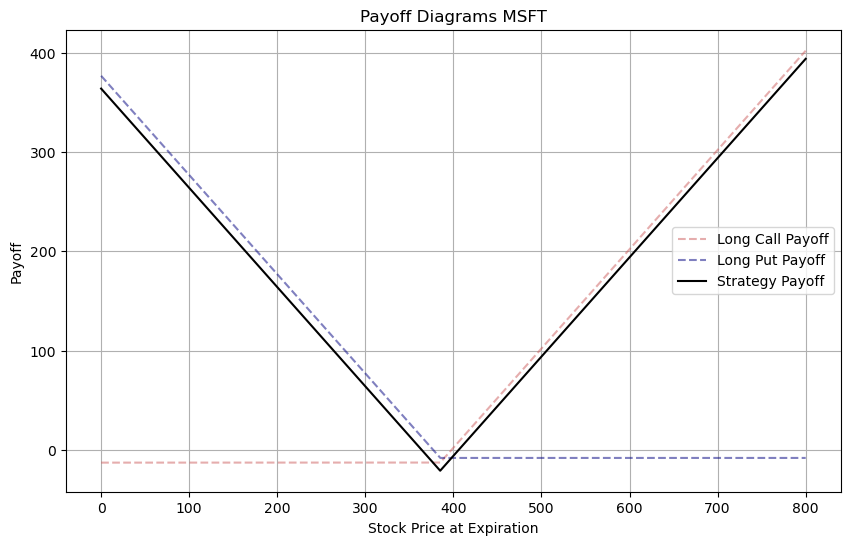

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.32
El rendimiento esperado de la estrategia es de 1.53%
La probabilidad de ganancia es de 42.42%
El intervalo de confianza del 95% para el profit es de [-20.19988126894762, 40.79225652426336]



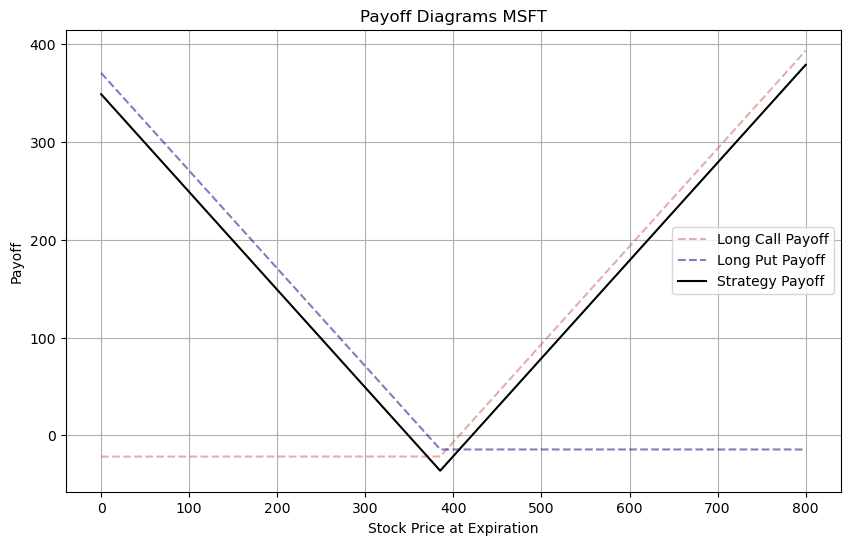

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.95
El rendimiento esperado de la estrategia es de 2.62%
La probabilidad de ganancia es de 42.95%
El intervalo de confianza del 95% para el profit es de [-34.771991996305864, 73.20661761518986]



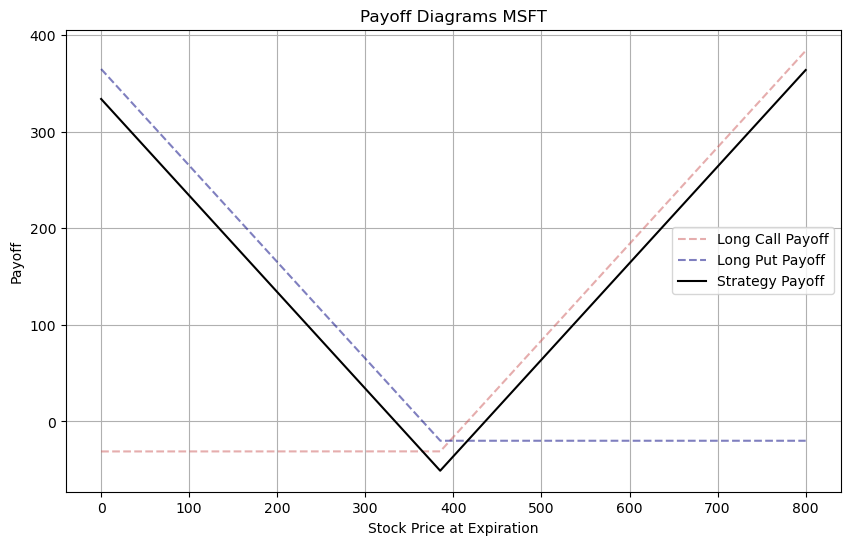

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $2.54
El rendimiento esperado de la estrategia es de 4.98%
La probabilidad de ganancia es de 43.24%
El intervalo de confianza del 95% para el profit es de [-48.92521692724612, 111.87511427634928]



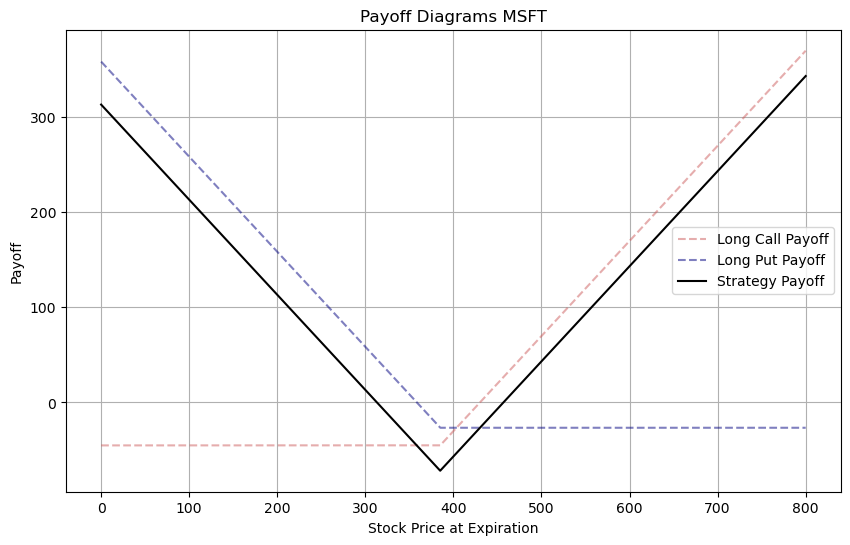

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $6.60
El rendimiento esperado de la estrategia es de 9.20%
La probabilidad de ganancia es de 43.71%
El intervalo de confianza del 95% para el profit es de [-68.95380988767273, 181.99070688217932]



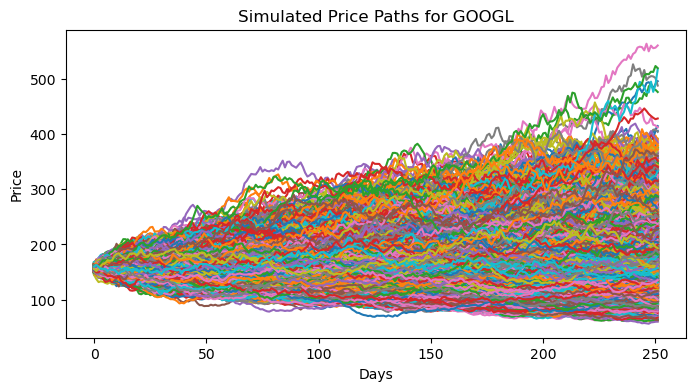

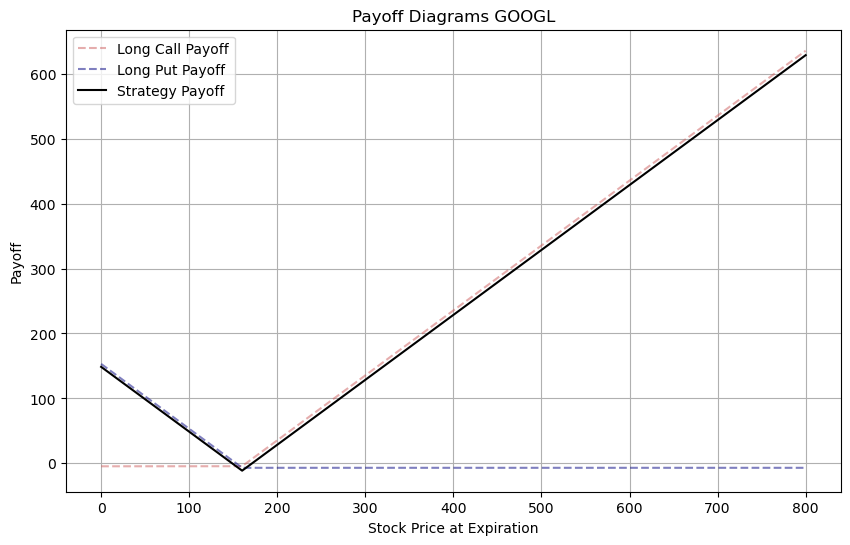

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-0.03
El rendimiento esperado de la estrategia es de -0.26%
La probabilidad de ganancia es de 42.51%
El intervalo de confianza del 95% para el profit es de [-10.889740042719374, 20.234198468630552]



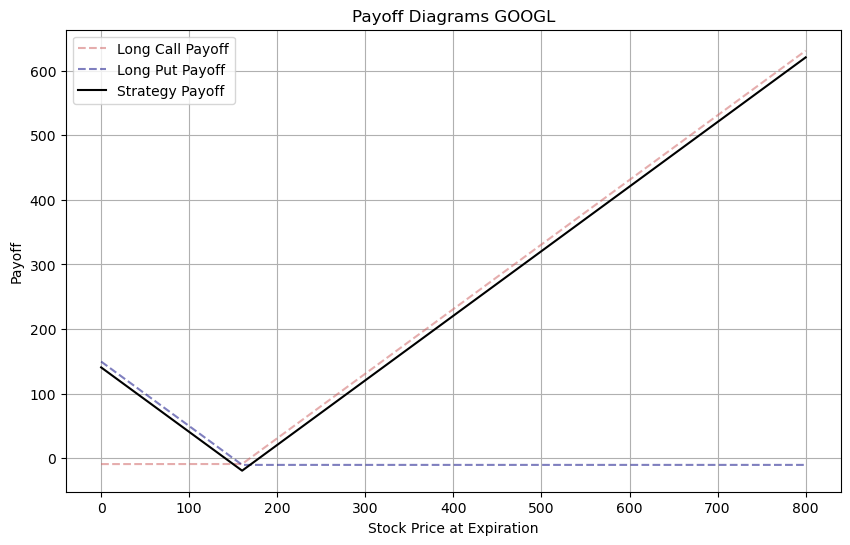

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.65
El rendimiento esperado de la estrategia es de 3.38%
La probabilidad de ganancia es de 43.27%
El intervalo de confianza del 95% para el profit es de [-18.55568031311331, 38.87808369271471]



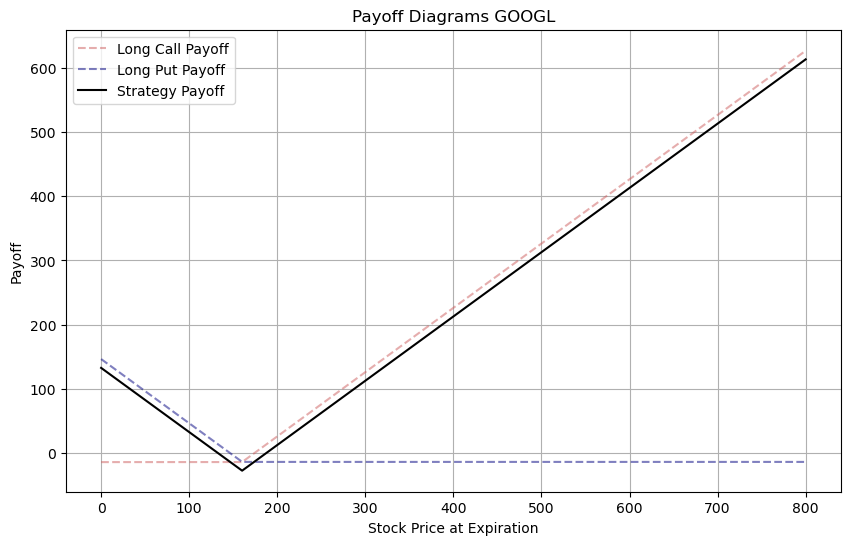

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $2.22
El rendimiento esperado de la estrategia es de 8.18%
La probabilidad de ganancia es de 44.13%
El intervalo de confianza del 95% para el profit es de [-26.066030068252346, 65.68041587384585]



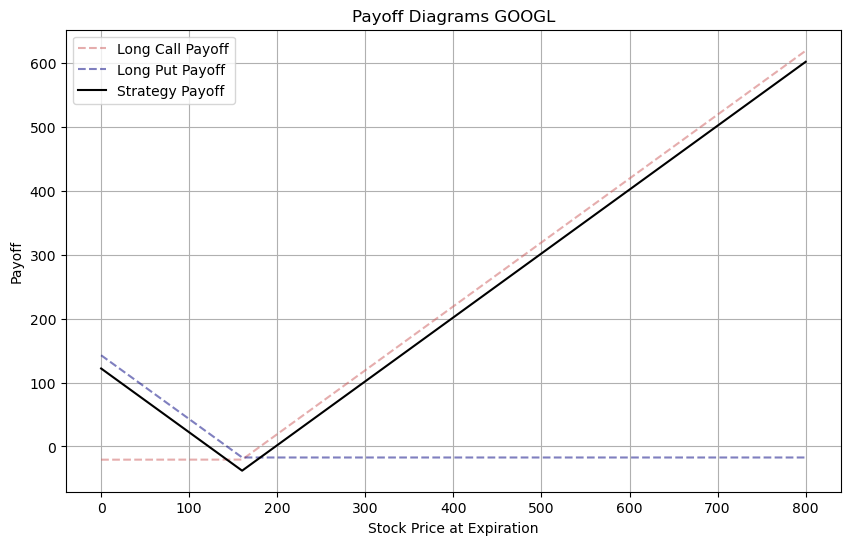

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $7.36
El rendimiento esperado de la estrategia es de 19.36%
La probabilidad de ganancia es de 46.09%
El intervalo de confianza del 95% para el profit es de [-36.46262431298689, 118.8549737306175]



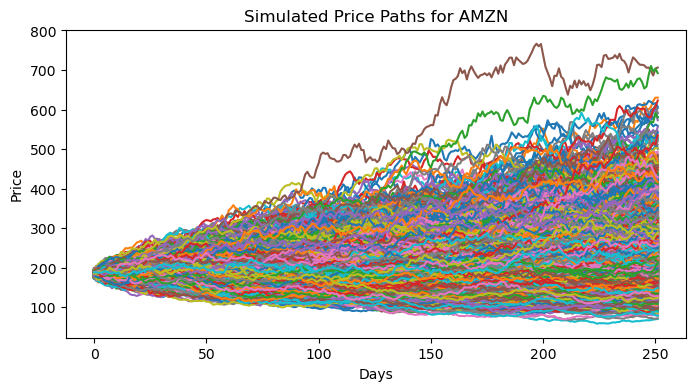

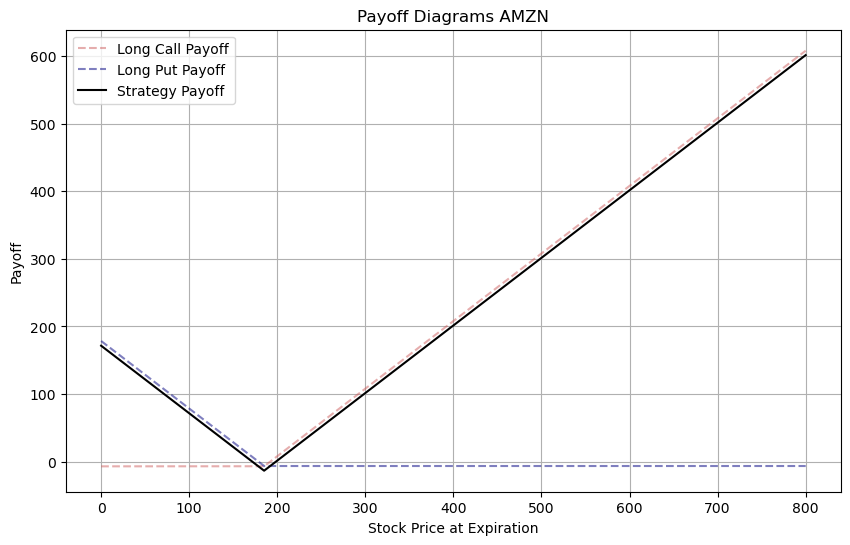

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.32
El rendimiento esperado de la estrategia es de 2.38%
La probabilidad de ganancia es de 43.18%
El intervalo de confianza del 95% para el profit es de [-12.954772379158204, 26.364374013599672]



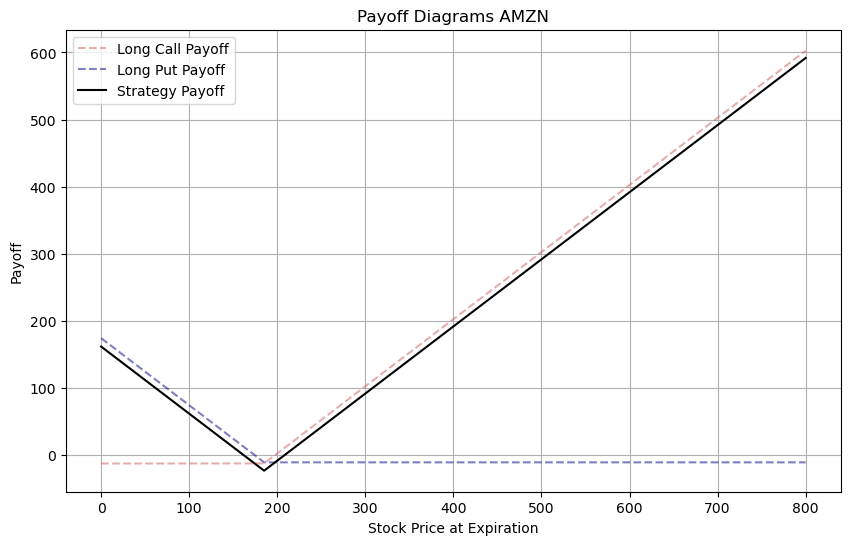

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $2.09
El rendimiento esperado de la estrategia es de 8.98%
La probabilidad de ganancia es de 44.77%
El intervalo de confianza del 95% para el profit es de [-22.370573362270363, 54.644220058321004]



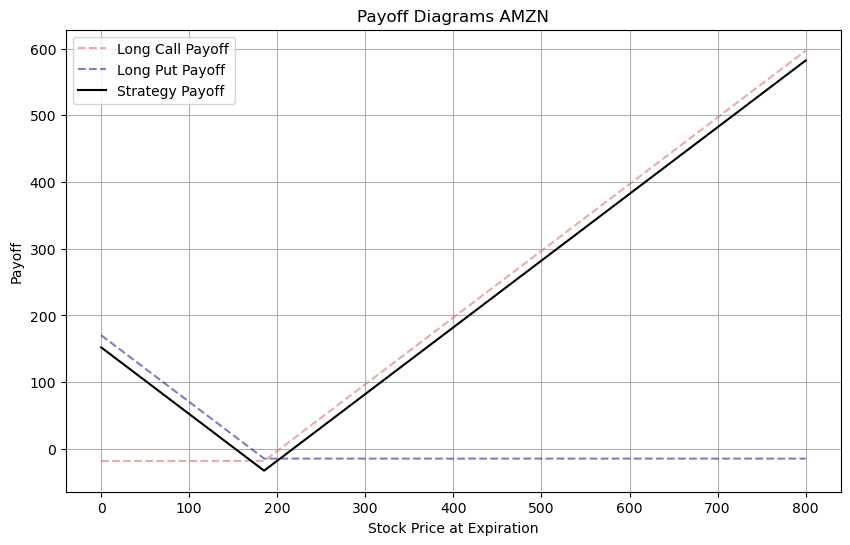

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $6.03
El rendimiento esperado de la estrategia es de 18.39%
La probabilidad de ganancia es de 46.72%
El intervalo de confianza del 95% para el profit es de [-31.38643980686372, 93.96654424366692]



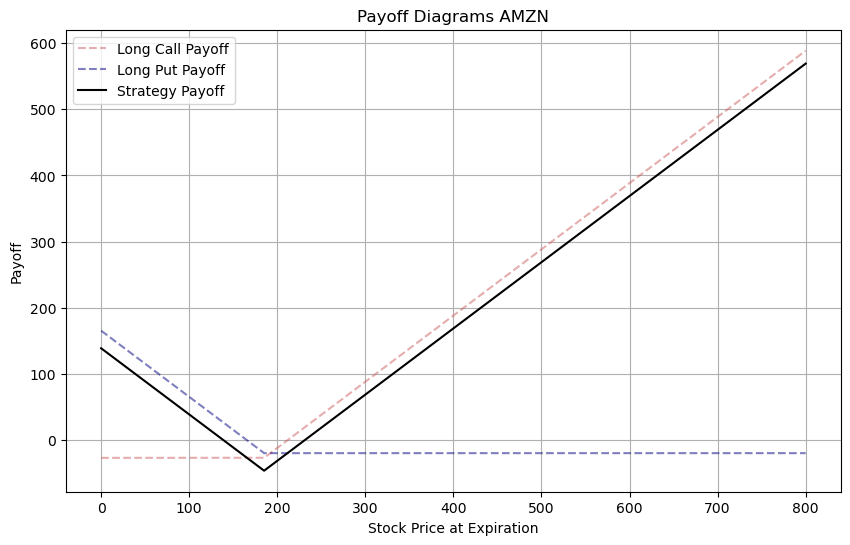

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $17.60
El rendimiento esperado de la estrategia es de 38.24%
La probabilidad de ganancia es de 50.34%
El intervalo de confianza del 95% para el profit es de [-43.935907246597175, 175.6258092485422]



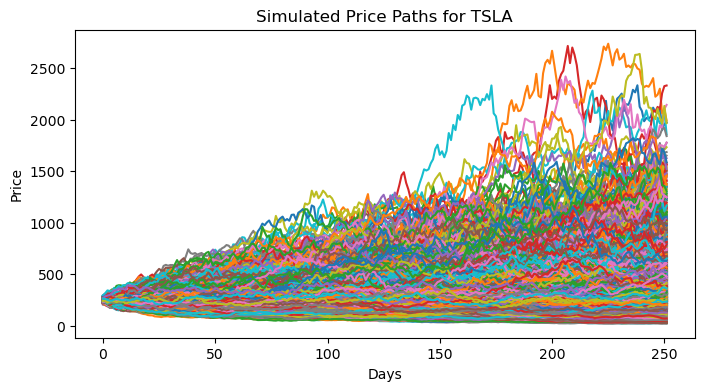

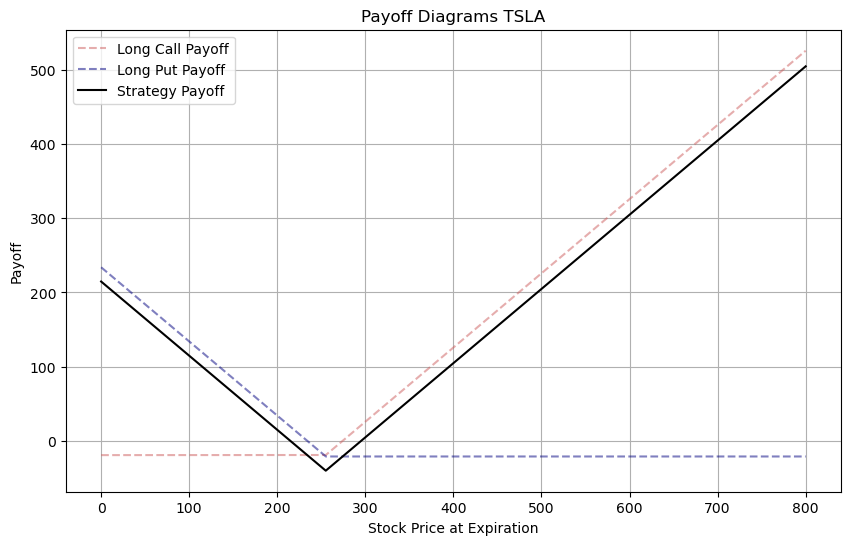

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.35
El rendimiento esperado de la estrategia es de 0.86%
La probabilidad de ganancia es de 42.28%
El intervalo de confianza del 95% para el profit es de [-38.63520683956934, 78.50504578632804]



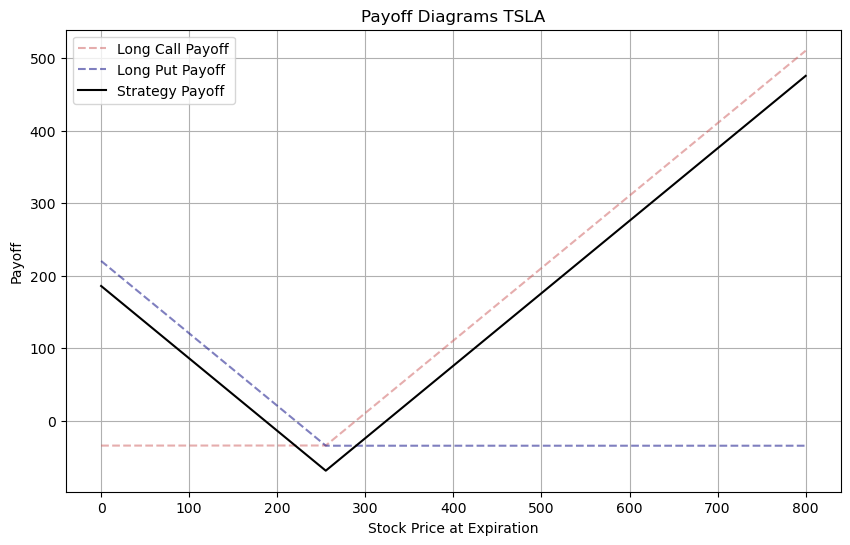

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $3.22
El rendimiento esperado de la estrategia es de 4.65%
La probabilidad de ganancia es de 42.35%
El intervalo de confianza del 95% para el profit es de [-66.55646219345678, 169.93041423313954]



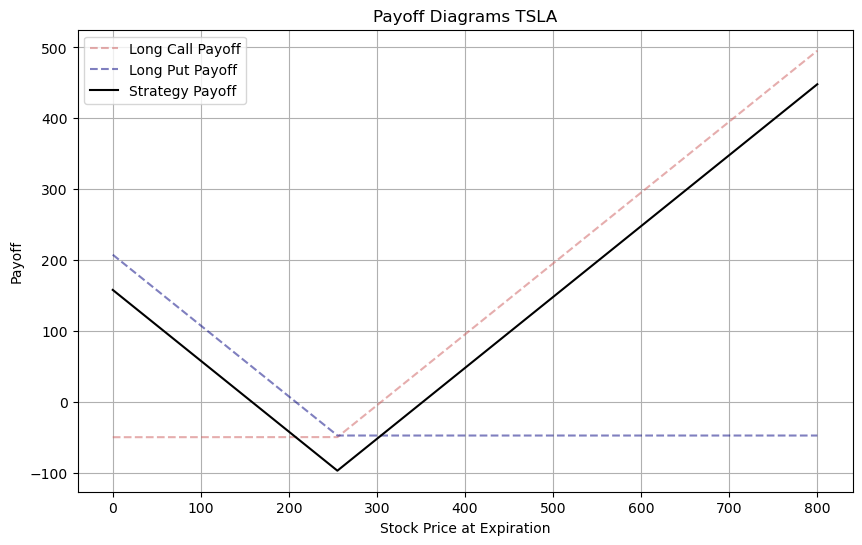

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $9.92
El rendimiento esperado de la estrategia es de 10.23%
La probabilidad de ganancia es de 41.76%
El intervalo de confianza del 95% para el profit es de [-93.0628291748571, 304.8504079235866]



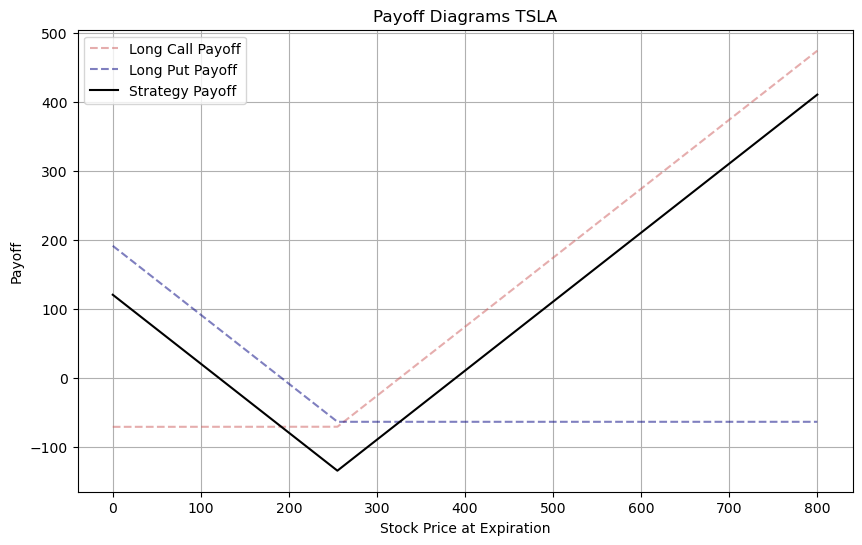

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $30.34
El rendimiento esperado de la estrategia es de 22.56%
La probabilidad de ganancia es de 40.91%
El intervalo de confianza del 95% para el profit es de [-129.08378421066496, 592.6930698486626]



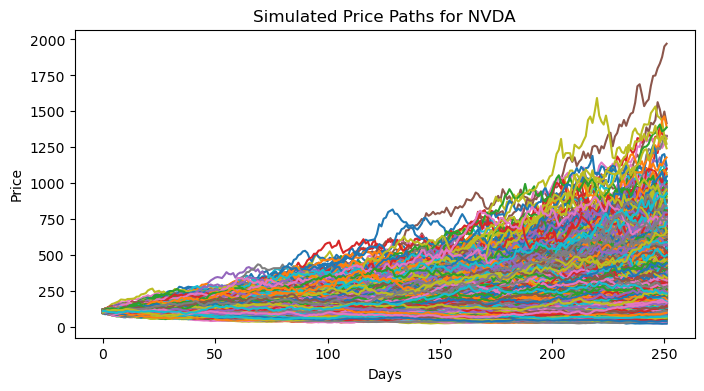

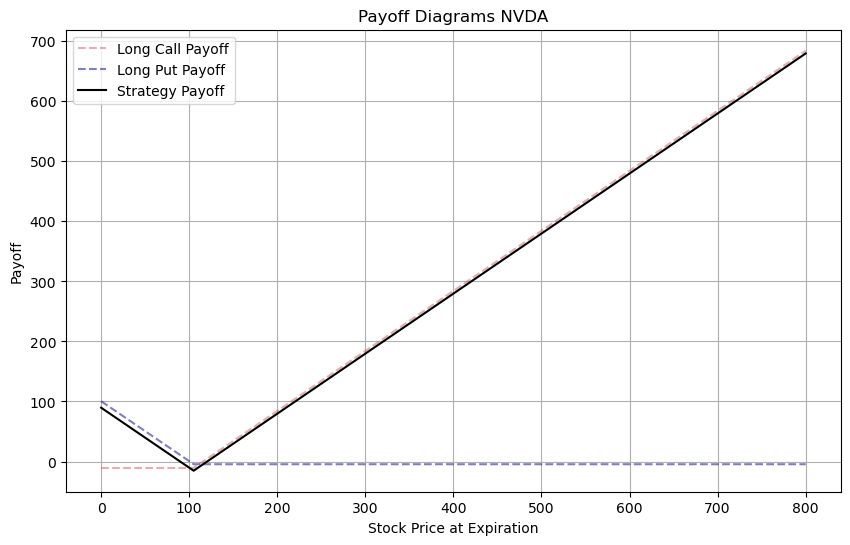

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $3.64
El rendimiento esperado de la estrategia es de 23.73%
La probabilidad de ganancia es de 49.94%
El intervalo de confianza del 95% para el profit es de [-14.657546686606967, 42.537731688716654]



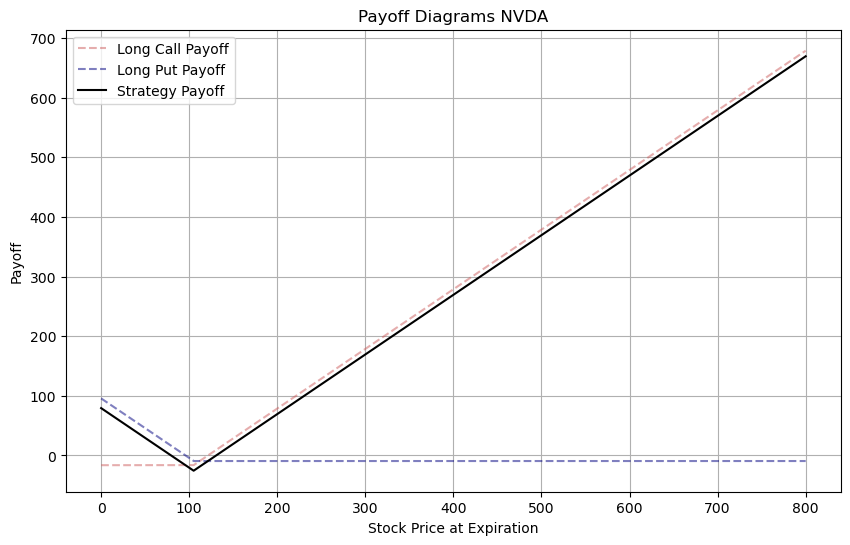

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $13.02
El rendimiento esperado de la estrategia es de 50.87%
La probabilidad de ganancia es de 54.98%
El intervalo de confianza del 95% para el profit es de [-24.296441853326815, 100.90450376638303]



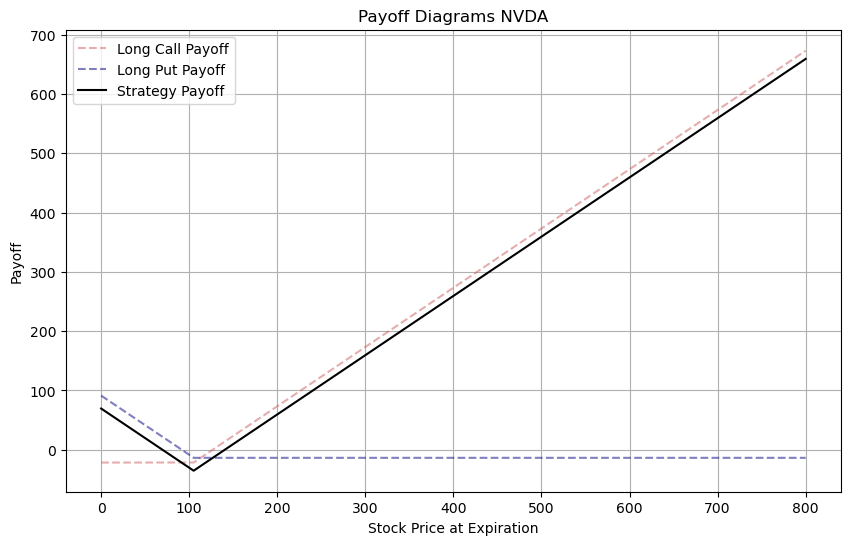

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $34.10
El rendimiento esperado de la estrategia es de 95.81%
La probabilidad de ganancia es de 61.51%
El intervalo de confianza del 95% para el profit es de [-33.47076130693025, 203.12488807105595]



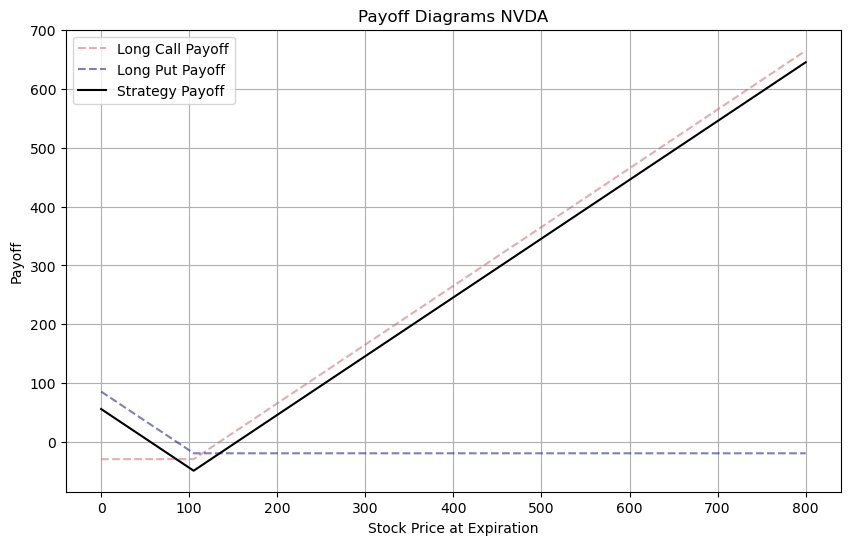

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $104.55
El rendimiento esperado de la estrategia es de 211.89%
La probabilidad de ganancia es de 72.36%
El intervalo de confianza del 95% para el profit es de [-45.157112562116026, 515.4215281330506]



In [7]:
straddle = MultiStraddle(tickers, '2024-01-01', '2025-04-14', strikes)
straddle.execute()